In [14]:
import os
from glob import glob
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Setting

In [15]:
## Load Anipose triangulation results
data_dir = r"/media/yiting/NewVolume/Data/Videos"
analysis_dir = r"/media/yiting/NewVolume/Analysis"
session_name = "2025-12-09"
ap_dir = os.path.join(analysis_dir, session_name, "anipose")
filtered3d_dir = os.path.join(ap_dir, "pose_3d_filter")
f3d_files = sorted(os.listdir(filtered3d_dir))


In [16]:
# Define the reference plane using top and bottom points
object_points = ['Dot_b2', 'Dot_t2', 'Dot_t3']
hand_points = ['Wrist_U', 'Palm', 'Wrist_R']

frame_rate = 100  # frames per second
time_window = [3, 3.5]
start_frame = round(time_window[0] * frame_rate)
end_frame = round(time_window[1] * frame_rate)

# Initialize lists to store results
object_plane_results = []
hand_plane_results = []

for f3d_file in f3d_files:
    # Load 3D filtered data
    f3d_df = pd.read_csv(os.path.join(filtered3d_dir, f3d_file))
    # Get object plane points
    object_plane_points = f3d_df[[f"{kp}_x" for kp in object_points] +
                                [f"{kp}_y" for kp in object_points] + 
                                [f"{kp}_z" for kp in object_points]].values.reshape(-1, 3, 3)[start_frame:end_frame]
    object_plane_points = object_plane_points.transpose(0, 2, 1) # Transpose to shape (num_frames, num_keypoints, num_coordinates(x,y,z))
    object_plane_results.append(object_plane_points)
    # Get palm and wrist points
    hand_plane_points = f3d_df[[f"{hp}_x" for hp in hand_points] + 
                                [f"{hp}_y" for hp in hand_points] + 
                                [f"{hp}_z" for hp in hand_points]].values.reshape(-1, 3, 3)[start_frame:end_frame]
    hand_plane_points = hand_plane_points.transpose(0, 2, 1)
    hand_plane_results.append(hand_plane_points)

In [17]:
print('Object shape:', np.array(object_plane_results).shape)
print('Hand shape:', np.array(hand_plane_results).shape)

Object shape: (999, 50, 3, 3)
Hand shape: (999, 50, 3, 3)


In [18]:
# Get normals and centroids
def compute_plane_normals_and_centroids(plane_points):
    vec1 = plane_points[:, :, 1] - plane_points[:, :, 0]
    vec2 = plane_points[:, :, 2] - plane_points[:, :, 0]
    normals = np.cross(vec1, vec2)
    normals /= np.linalg.norm(normals, axis=1, keepdims=True)
    centroids = np.mean(plane_points, axis=2)
    return normals, centroids

In [19]:
normals_object, centroids_object = compute_plane_normals_and_centroids(np.concatenate(object_plane_results, axis=0))
normals_object_mean = np.nanmean(normals_object, axis=0)
normals_object_std = np.nanstd(normals_object, axis=0)
normals_object_sem = normals_object_std / np.sqrt(normals_object.shape[0])
centroids_object_mean = np.nanmean(centroids_object, axis=0)
centroids_object_std = np.nanstd(centroids_object, axis=0)
centroids_object_sem = centroids_object_std / np.sqrt(centroids_object.shape[0])
print('Object Normals Mean:', normals_object_mean)
print('Object Normals SEM:', normals_object_sem)
print('Object Centroids Mean:', centroids_object_mean)
print('Object Centroids SEM:', centroids_object_sem)


Object Normals Mean: [ 0.71881599 -0.37066098 -0.34702289]
Object Normals SEM: [0.00119173 0.00148105 0.00094898]
Object Centroids Mean: [331.23399193 335.89456869 337.87292216]
Object Centroids SEM: [0.01520562 0.01012999 0.00890384]


In [20]:
# Compute hand normals and centroids
hand_plane_normals = []
hand_plane_centroids = []

for idx, hand_plane_points in enumerate(hand_plane_results):
    # 1. Check if array has 0 elements
    if hand_plane_points.size == 0:
        print(f"Hand plane points empty for file index {idx}, skipping.")
        hand_plane_normals.append(np.array([np.nan, np.nan, np.nan])) # Append NaN to keep index alignment
        hand_plane_centroids.append(np.array([np.nan, np.nan, np.nan]))
        continue

    # Compute per-frame normals and centroids
    # (Assuming compute_plane_normals_and_centroids is defined and returns (N,3) arrays)
    normals_hand, centroids_hand = compute_plane_normals_and_centroids(hand_plane_points)
    
    # 2. Take the average (ignoring NaNs)
    # Check if we have valid data before averaging to avoid RuntimeWarnings
    if np.all(np.isnan(normals_hand)):
        print(f"File index {idx} contains only NaNs.")
        mean_normal = np.array([np.nan, np.nan, np.nan])
        mean_centroid = np.array([np.nan, np.nan, np.nan])
    else:
        mean_normal = np.nanmean(normals_hand, axis=0)
        mean_centroid = np.nanmean(centroids_hand, axis=0)

        # 3. Re-normalize the averaged normal vector
        # The arithmetic mean of unit vectors is not a unit vector.
        norm_magnitude = np.linalg.norm(mean_normal)
        if norm_magnitude > 1e-6: # Avoid division by zero
            mean_normal /= norm_magnitude

    hand_plane_normals.append(mean_normal)
    hand_plane_centroids.append(mean_centroid)

# Convert lists to arrays for easier analysis later
hand_plane_normals = np.array(hand_plane_normals)
hand_plane_centroids = np.array(hand_plane_centroids)


File index 132 contains only NaNs.
File index 528 contains only NaNs.
File index 540 contains only NaNs.
File index 562 contains only NaNs.
File index 580 contains only NaNs.
File index 604 contains only NaNs.
File index 605 contains only NaNs.
File index 606 contains only NaNs.
File index 607 contains only NaNs.
File index 608 contains only NaNs.
File index 609 contains only NaNs.
File index 610 contains only NaNs.
File index 611 contains only NaNs.
File index 645 contains only NaNs.
File index 660 contains only NaNs.
File index 665 contains only NaNs.
File index 666 contains only NaNs.
File index 667 contains only NaNs.
File index 670 contains only NaNs.
File index 671 contains only NaNs.
File index 672 contains only NaNs.
File index 673 contains only NaNs.
File index 689 contains only NaNs.
File index 696 contains only NaNs.
File index 697 contains only NaNs.
File index 698 contains only NaNs.
File index 725 contains only NaNs.
File index 726 contains only NaNs.
File index 727 conta

In [21]:
print(hand_plane_normals.shape)
print(hand_plane_centroids.shape)

(999, 3)
(999, 3)


In [22]:
# Compute angles between hand normals and object normals
angles_deg_list = []
# Compute centroid distances
centroid_distances = []
for normal, centroid in zip(hand_plane_normals, hand_plane_centroids):
    # 1. Compute angle between hand normal and object normal
    # Dot product: a . b = |a||b|cos(theta) -> cos(theta) = a . b (since normalized)
    dot_product = np.dot(normal, normals_object_mean)
    
    # Clip to handle floating point errors slightly outside [-1, 1]
    dot_product = np.clip(dot_product, -1.0, 1.0)
    
    # Calculate angle in degrees (0 to 180)
    angles_deg = np.degrees(np.arccos(dot_product))

    angles_deg_list.append(angles_deg)

    # 2. Compute centroid distance
    distance = np.linalg.norm(centroid - centroids_object_mean)
    centroid_distances.append(distance)

Text(0, 0.5, 'Frequency')

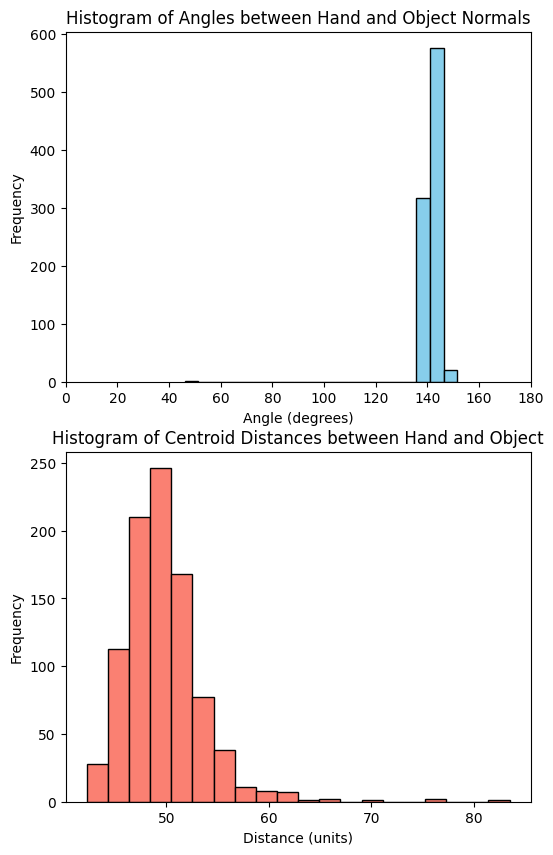

In [23]:
# Plot histogram of angles and centroid distances
plt.figure(figsize=(6, 10))
plt.subplot(2, 1, 1)
plt.hist(angles_deg_list, bins=20, color='skyblue', edgecolor='black')
plt.xlim(0, 180)
plt.title('Histogram of Angles between Hand and Object Normals')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.subplot(2, 1, 2)
plt.hist(centroid_distances, bins=20, color='salmon', edgecolor='black')
plt.title('Histogram of Centroid Distances between Hand and Object')
plt.xlabel('Distance (units)')
plt.ylabel('Frequency')

### Get logs

In [ ]:
# Create a table
# 1. Extract angles from the holding time
# 2. Add trial name and shape id
df = pd.DataFrame()
for log_trial,angle_trial in zip(log_trials, angle_trials):
    
    angle_df = pd.read_csv(os.path.join(angle_dir, angle_trial))
    # Open and read the JSON file
    with open(os.path.join(log_dir, log_trial), 'r') as file:
        json_data = json.load(file)

    new_df = angle_df.loc[[frame_number]]
    new_df["trial_name"] = log_trial[11:19]
    new_df["shape_id"] = json_data["shape_id"]
    new_df["correct"] = json_data["has_played_success_tone"]
    new_df["is_holdshort"] = json_data["object_released"]
    new_df["is_holdlong"] = json_data["object_held"]
    new_df["is_sameShape"] = json_data["reward_direction"] == 'holdshort'

    df = pd.concat([df,new_df])
    
df.reset_index(drop=True, inplace=True)
